In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import datetime as dt
import os
import json

plt.rc('axes', axisbelow=True)
%matplotlib inline

# Prospective resilience
Given that the prospective resilience is computed by adding nodes to a network, the mechanism by which nodes are added becomes an important consideration. In general, node attachment mechanisms assign a probability that each incoming node, $v_{t+1}$, attaches its $m$ disconnected links (often referred to as "dangling" edges in network science) to nodes already in the network, $v_i \in V$. This could be based on \textit{random} attachment, where each node, $v_i$, has a probability $p_i = \frac{1}{N}$ of becoming connected to the incoming node, $v_{t+1}$. Similarly, a new node can add its $m$ link preferentially based on the \textit{degree} (number of neighbors) of the nodes in the network, $p_i \propto k_i$, where $k_i$ is the degree of node $v_i$. To get the explicit probability formula, we realise that the sum of degrees in the network is just twice the number of links so that, for degree-based preferential attachment, $p_{i} = \frac{k_{i}}{2m}$.

From the biological perspective, we posited that a novel protein entering a system is inevitably more likely to interact with proteins which are more abundant in that system. This abundance can be determined by the protein's gene expression. To this end, we compare standard random and degree-based attachment mechanisms with attachment by gene expression. This is implemented exactly as for degree-based attachment. 'Probabilities' of each node are computed as the fraction of the node's gene expression to the sum total of gene expressions in the network. Novel proteins, being invented, do not have a known gene expression. Being new to the system, they are assumed to have standard levels of gene expression and are assigned the network average. Through this attachment rule, we explicitly couple insights from network science to the biological properties of protein networks.

In [2]:
def findFilesInFolder(path, pathList, extension, subFolders=True):
    """  
    Recursive function to find all files of an extension type in a 
    folder (and optionally in all subfolders too)

    path:        Base directory to find files
    pathList:    A list that stores all paths
    extension:   File extension to find
    subFolders:  Bool.  If True, find files in all subfolders under path. 
                 If False, only searches files in the specified folder
    """

    try:   # Trapping a OSError:  File permissions problem I believe
        for entry in os.scandir(path):
            if entry.is_file() and entry.path.endswith(extension):
                pathList.append(entry.path)
            elif entry.is_dir() and subFolders:   # if its a directory, then repeat process as a nested function
                pathList = findFilesInFolder(entry.path, pathList, extension, subFolders)
    except OSError:
        print('Cannot access ' + path +'. Probably a permissions error')

    return pathList

In [3]:
dir_name = '../../cluster/out/'
extension = ".json"
pathList = []
pathList = findFilesInFolder(dir_name, pathList, extension, True)
pathList = sorted(pathList)

In [4]:
species = ['eco', 'hsa', 'sce']
links_per_nodes = [4, 8, 16]
methods_used = ['bio_smart', 'degree', 'random']
values_measured = ['comm', 'pres']
noise_interval = np.linspace(0, 1, 11).round(3)

out_dict = {spec: 
             {meth: 
              {m: 
               {val: 
                {nois: [] for nois in noise_interval
                } for val in values_measured
               } for m in links_per_nodes
              } for meth in methods_used
            } for spec in species}

In [5]:
for i in range(len(pathList)):
    with open(pathList[i]) as loadfile:
        new_data_i = json.load(loadfile)

    spec = list(new_data_i.keys())[0]
    m_str = list(new_data_i[spec].keys())[0]
    m = int(m_str)
    meth = list(new_data_i[spec][m_str].keys())[0]
    for valtype in values_measured:
        for nois,vals in new_data_i[spec][m_str][meth][valtype].items():
            out_dict[spec][meth][m][valtype][float(nois)].append(vals)

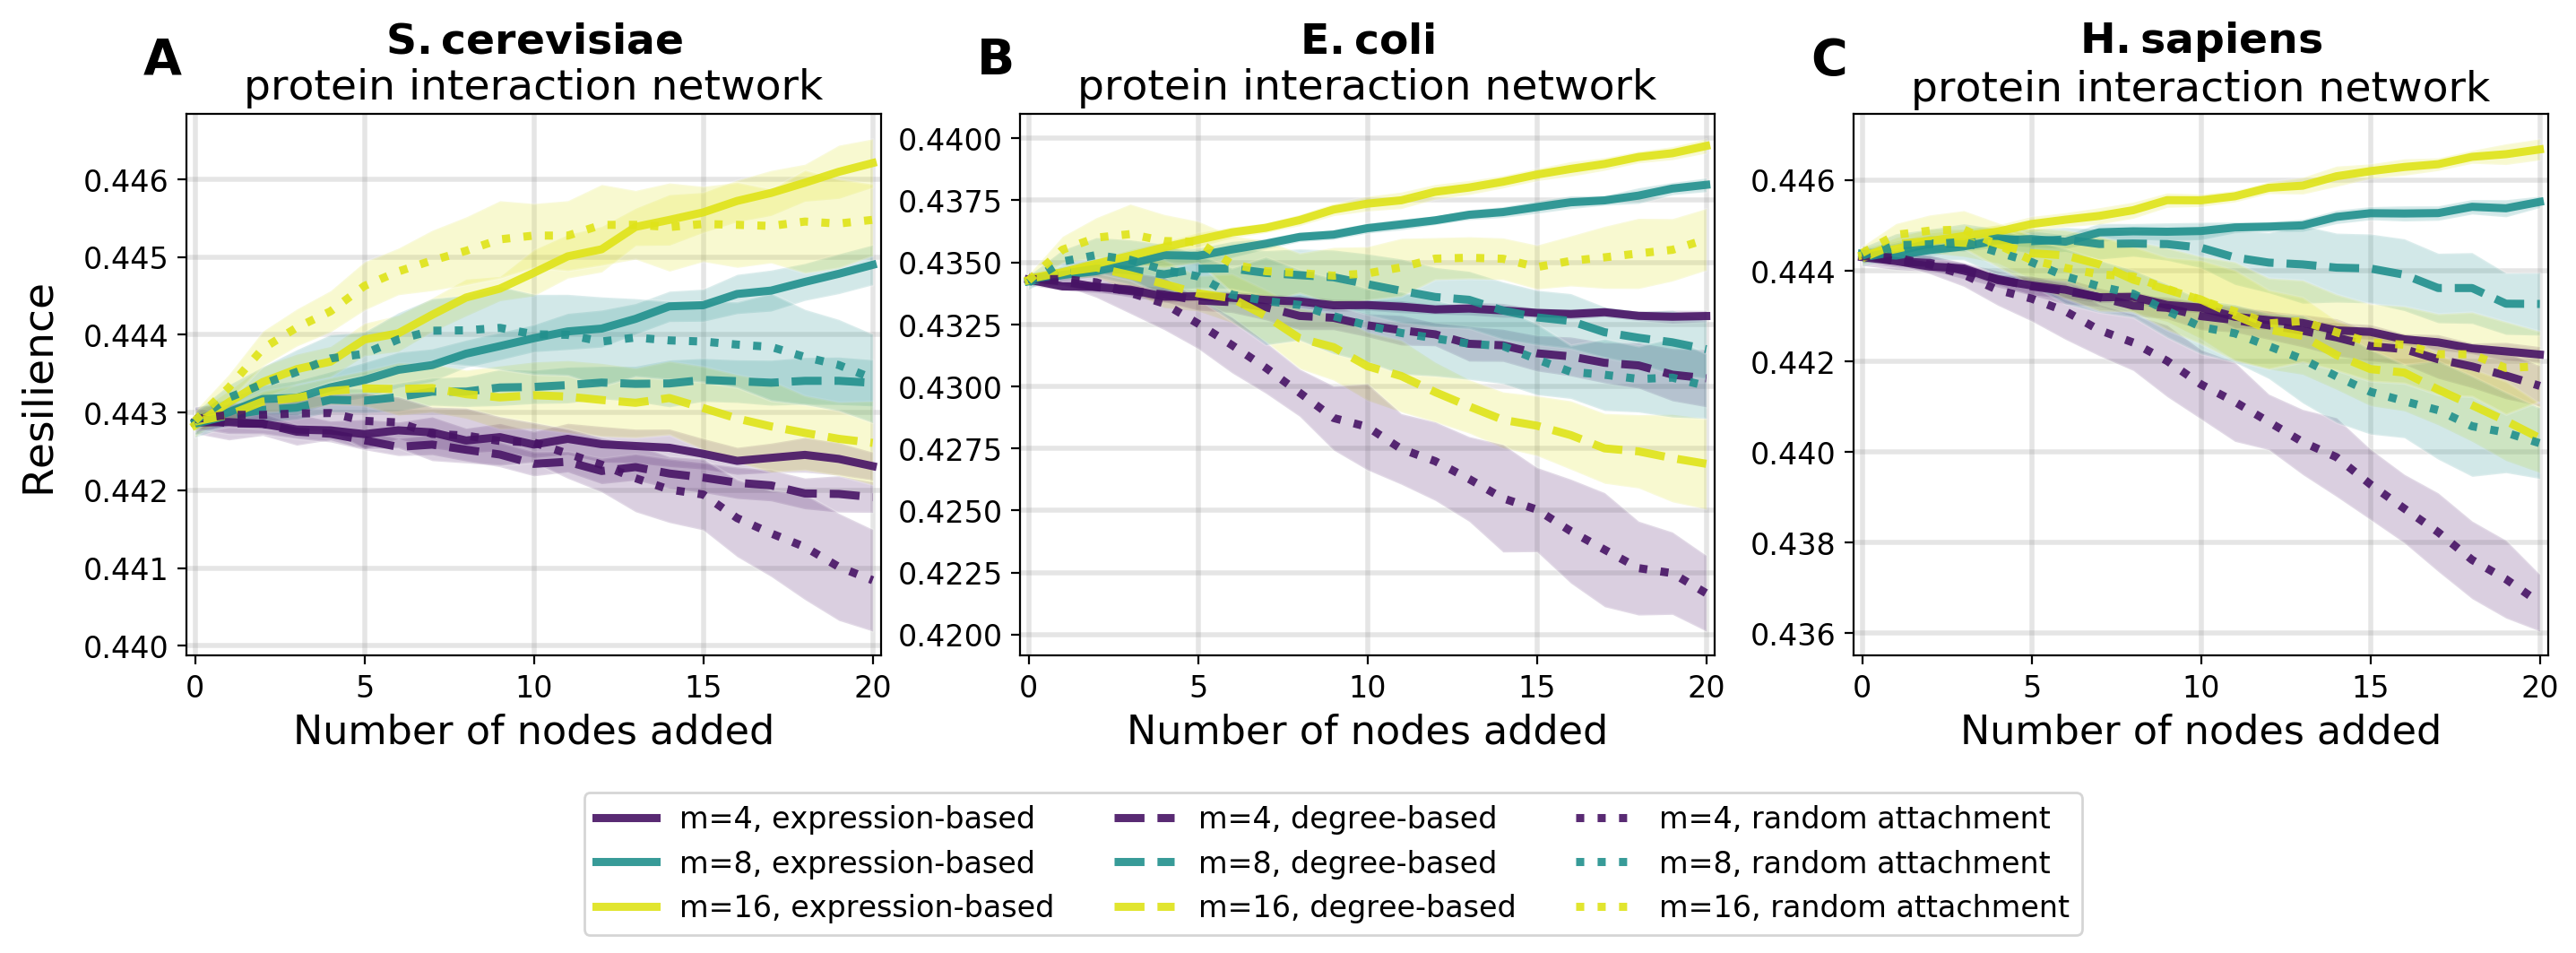

In [6]:
t_out = 20
ls = {"bio_smart":'-',"degree":'--',"random":':'}
labels = {'bio_smart':'expression-based', 'degree':'degree-based', 'random':'random attachment'}

titles = {'sce':r"$\bf{S. cerevisiae}$"+"\nprotein interaction network",
          'eco':r"$\bf{E. coli}$"+"\nprotein interaction network",
          'hsa':r"$\bf{H. sapiens}$"+"\nprotein interaction network"}

axes = {'sce':0, 'eco':1, 'hsa':2}

cols = plt.cm.viridis(np.linspace(0.05,0.95,len(links_per_nodes)))
cols = dict(zip(links_per_nodes, cols))

# fig, ax = plt.subplots(1, 3, figsize=(15,4), dpi=200, sharey=True)
# plt.subplots_adjust(hspace=0.015, wspace=0.1)
fig, ax = plt.subplots(1, 3, figsize=(17,4), dpi=200)
plt.subplots_adjust(hspace=0.015, wspace=0.2)

valtype = 'pres'

for spec, spec_meth_dat in out_dict.items():
    a = axes[spec]
    for meth, m_dat in spec_meth_dat.items():
        for m_i, noise_data in m_dat.items():
            dat_i = m_dat[m_i][valtype][0.0]
            if len(dat_i) > 1:
                means = np.array(dat_i).mean(axis=0)
                stdvs = np.array(dat_i).std(axis=0)
                xvals = np.linspace(0,t_out,len(means))
                
                lab = labels[meth]
                ax[a].plot(xvals, means, label='m=%s, %s'%(m_i, lab), linestyle=ls[meth],
                         color=cols[m_i], linewidth=3.25, alpha=0.9)

                ax[a].fill_between(xvals, means-stdvs, means+stdvs, facecolor=cols[m_i],
                                    linewidth=1, alpha=0.2, edgecolor='w')

    
    ax[a].grid(linestyle='-', linewidth=2, alpha=0.25, color='#999999')
    ax[a].set_xlabel("Number of nodes added", fontsize=16)
    ax[a].set_xticks(np.linspace(0, t_out, 5))
    ax[a].set_xticklabels(np.linspace(0, t_out, 5, dtype=int))
    ax[a].set_xlim(-0.25, t_out+0.25)
    ax[a].tick_params(axis='both', which='major', labelsize=12)
    
    ax[a].set_title(titles[spec],fontsize=17)    

    
ax[0].legend(fontsize=12, bbox_to_anchor=[2.75, -0.225], ncol=3)
alphabet = ['A', 'B', 'C']
for ai, a in enumerate(fig.axes):
    a.text(-0.035, 1.1, alphabet[ai], fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=a.transAxes, fontweight='bold')

ax[0].set_ylabel("Resilience", fontsize=17, labelpad=10)

plt.savefig('../figs/pngs/clusterdata_Presilience.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/clusterdata_Presilience.pdf',bbox_inches='tight')
plt.show()

_______________

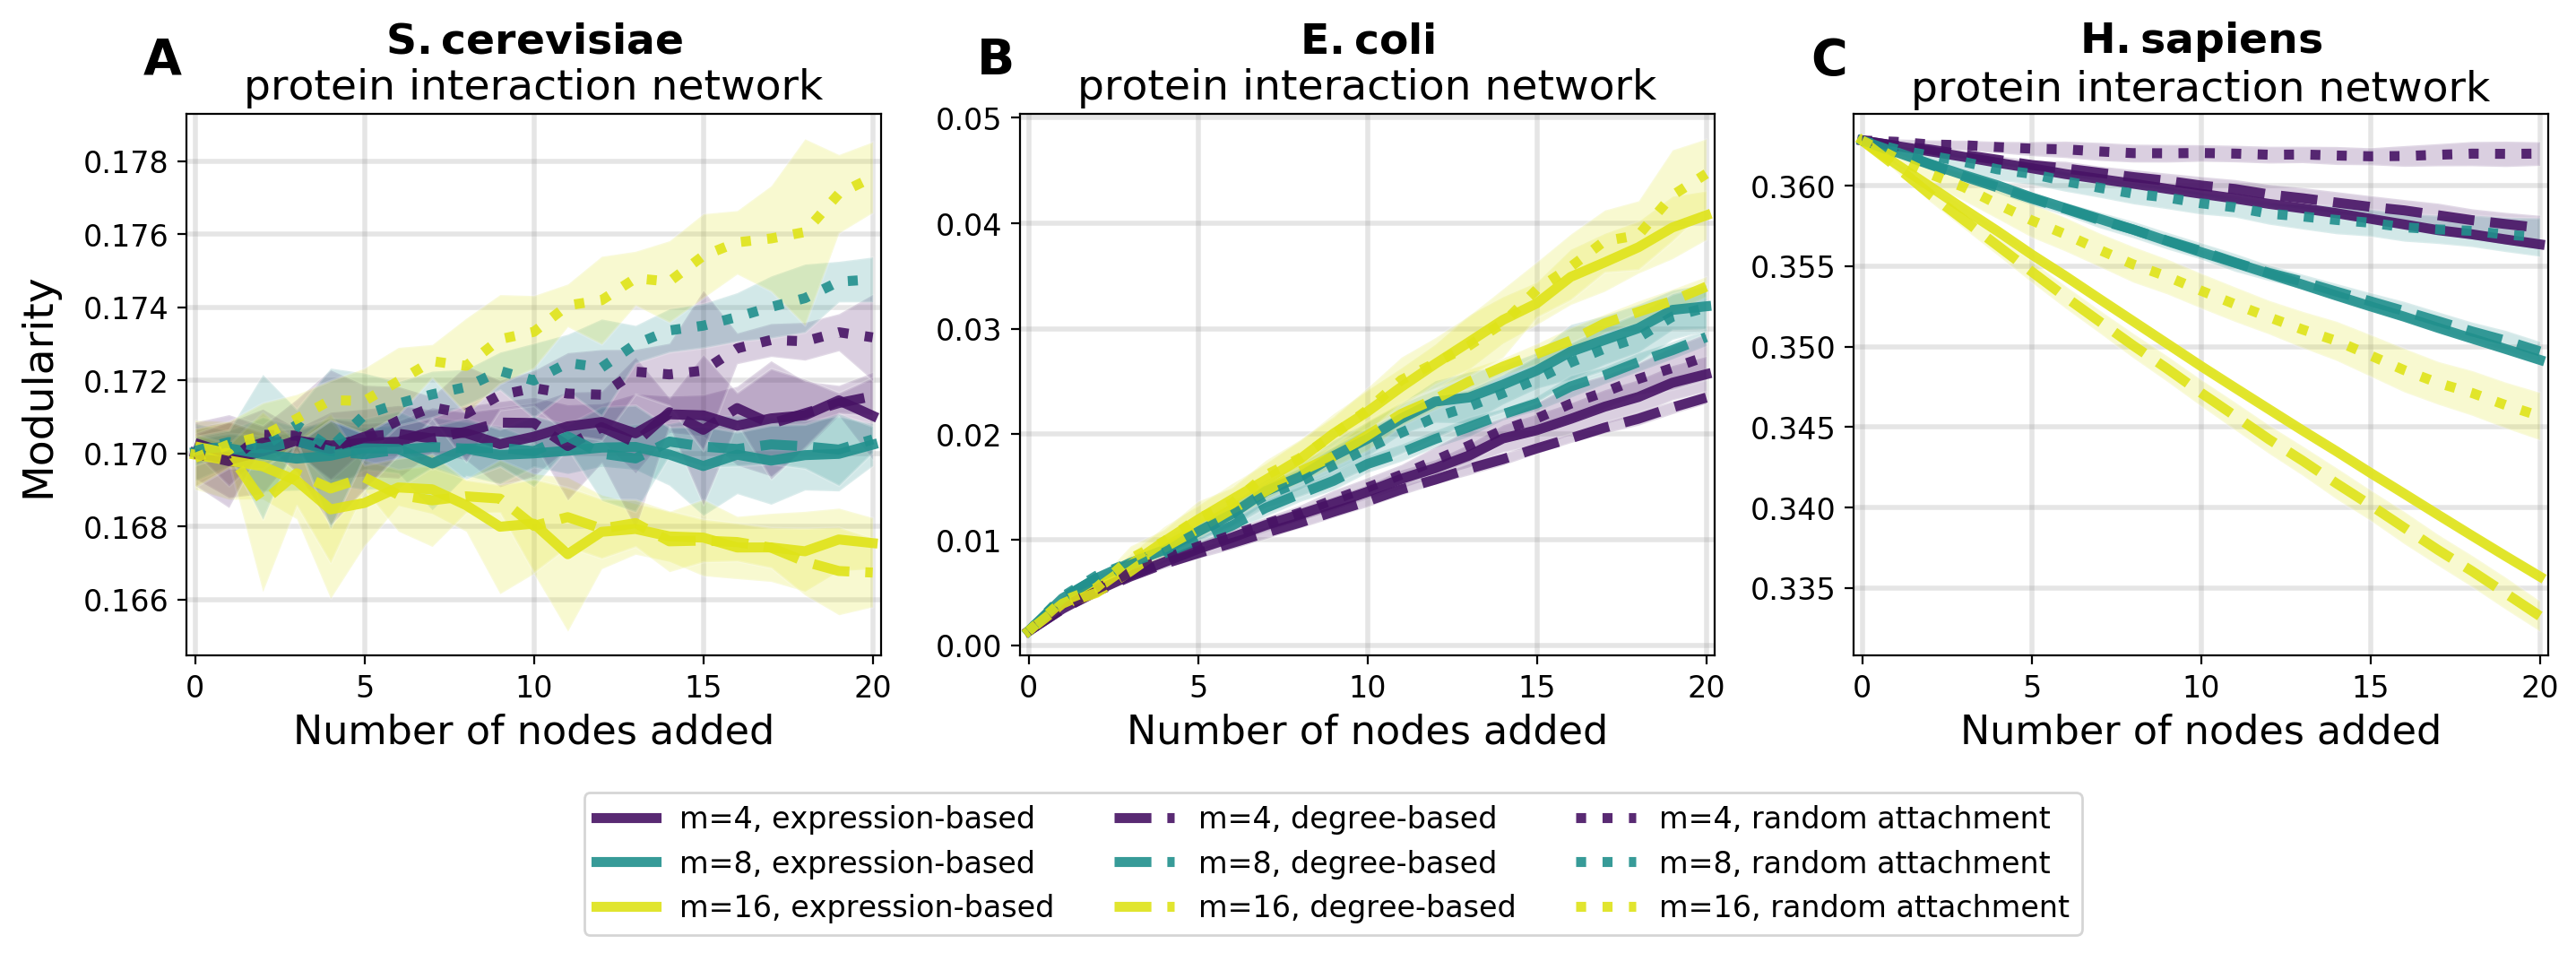

In [7]:
t_out = 20
ls = {"bio_smart":'-',"degree":'--',"random":':'}
labels = {'bio_smart':'expression-based', 'degree':'degree-based', 'random':'random attachment'}

titles = {'sce':r"$\bf{S. cerevisiae}$"+"\nprotein interaction network",
          'eco':r"$\bf{E. coli}$"+"\nprotein interaction network",
          'hsa':r"$\bf{H. sapiens}$"+"\nprotein interaction network"}

axes = {'sce':0, 'eco':1, 'hsa':2}

cols = plt.cm.viridis(np.linspace(0.05,0.95,len(links_per_nodes)))
cols = dict(zip(links_per_nodes, cols))

fig, ax = plt.subplots(1, 3, figsize=(17,4), dpi=200)#, sharey=True)
plt.subplots_adjust(hspace=0.015, wspace=0.2)

valtype = 'comm'

for spec, spec_meth_dat in out_dict.items():
    a = axes[spec]
    for meth, m_dat in spec_meth_dat.items():
        for m_i, noise_data in m_dat.items():
            dat_i = m_dat[m_i][valtype][0.0]
            if len(dat_i) > 0:
                means = np.array(dat_i).mean(axis=0)
                stdvs = np.array(dat_i).std(axis=0)
                xvals = np.linspace(0,t_out,len(means))
                
                lab = labels[meth]
                ax[a].plot(xvals, means, label='m=%s, %s'%(m_i, lab), linestyle=ls[meth],
                         color=cols[m_i], linewidth=4, alpha=0.9)

                ax[a].fill_between(xvals, means-stdvs, means+stdvs, facecolor=cols[m_i],
                                    linewidth=1, alpha=0.2, edgecolor='w')

    ax[a].grid(linestyle='-', linewidth=2, alpha=0.25, color='#999999')
    ax[a].set_xlabel("Number of nodes added", fontsize=16)
    ax[a].set_xticks(np.linspace(0, t_out, 5))
    ax[a].set_xticklabels(np.linspace(0, t_out, 5, dtype=int))
    ax[a].set_xlim(-0.25, t_out+0.25)
    ax[a].tick_params(axis='both', which='major', labelsize=12)
    
    ax[a].set_title(titles[spec],fontsize=17)    

    
ax[0].legend(fontsize=12, bbox_to_anchor=[2.75, -0.225], ncol=3)
alphabet = ['A', 'B', 'C']
for ai, a in enumerate(fig.axes):
    a.text(-0.035, 1.1, alphabet[ai], fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=a.transAxes, fontweight='bold')

ax[0].set_ylabel("Modularity", fontsize=17, labelpad=10)

plt.savefig('../figs/pngs/clusterdata_Modularience.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/clusterdata_Modularience.pdf',bbox_inches='tight')
plt.show()

_________________

In [8]:
from utilities import average_every_n

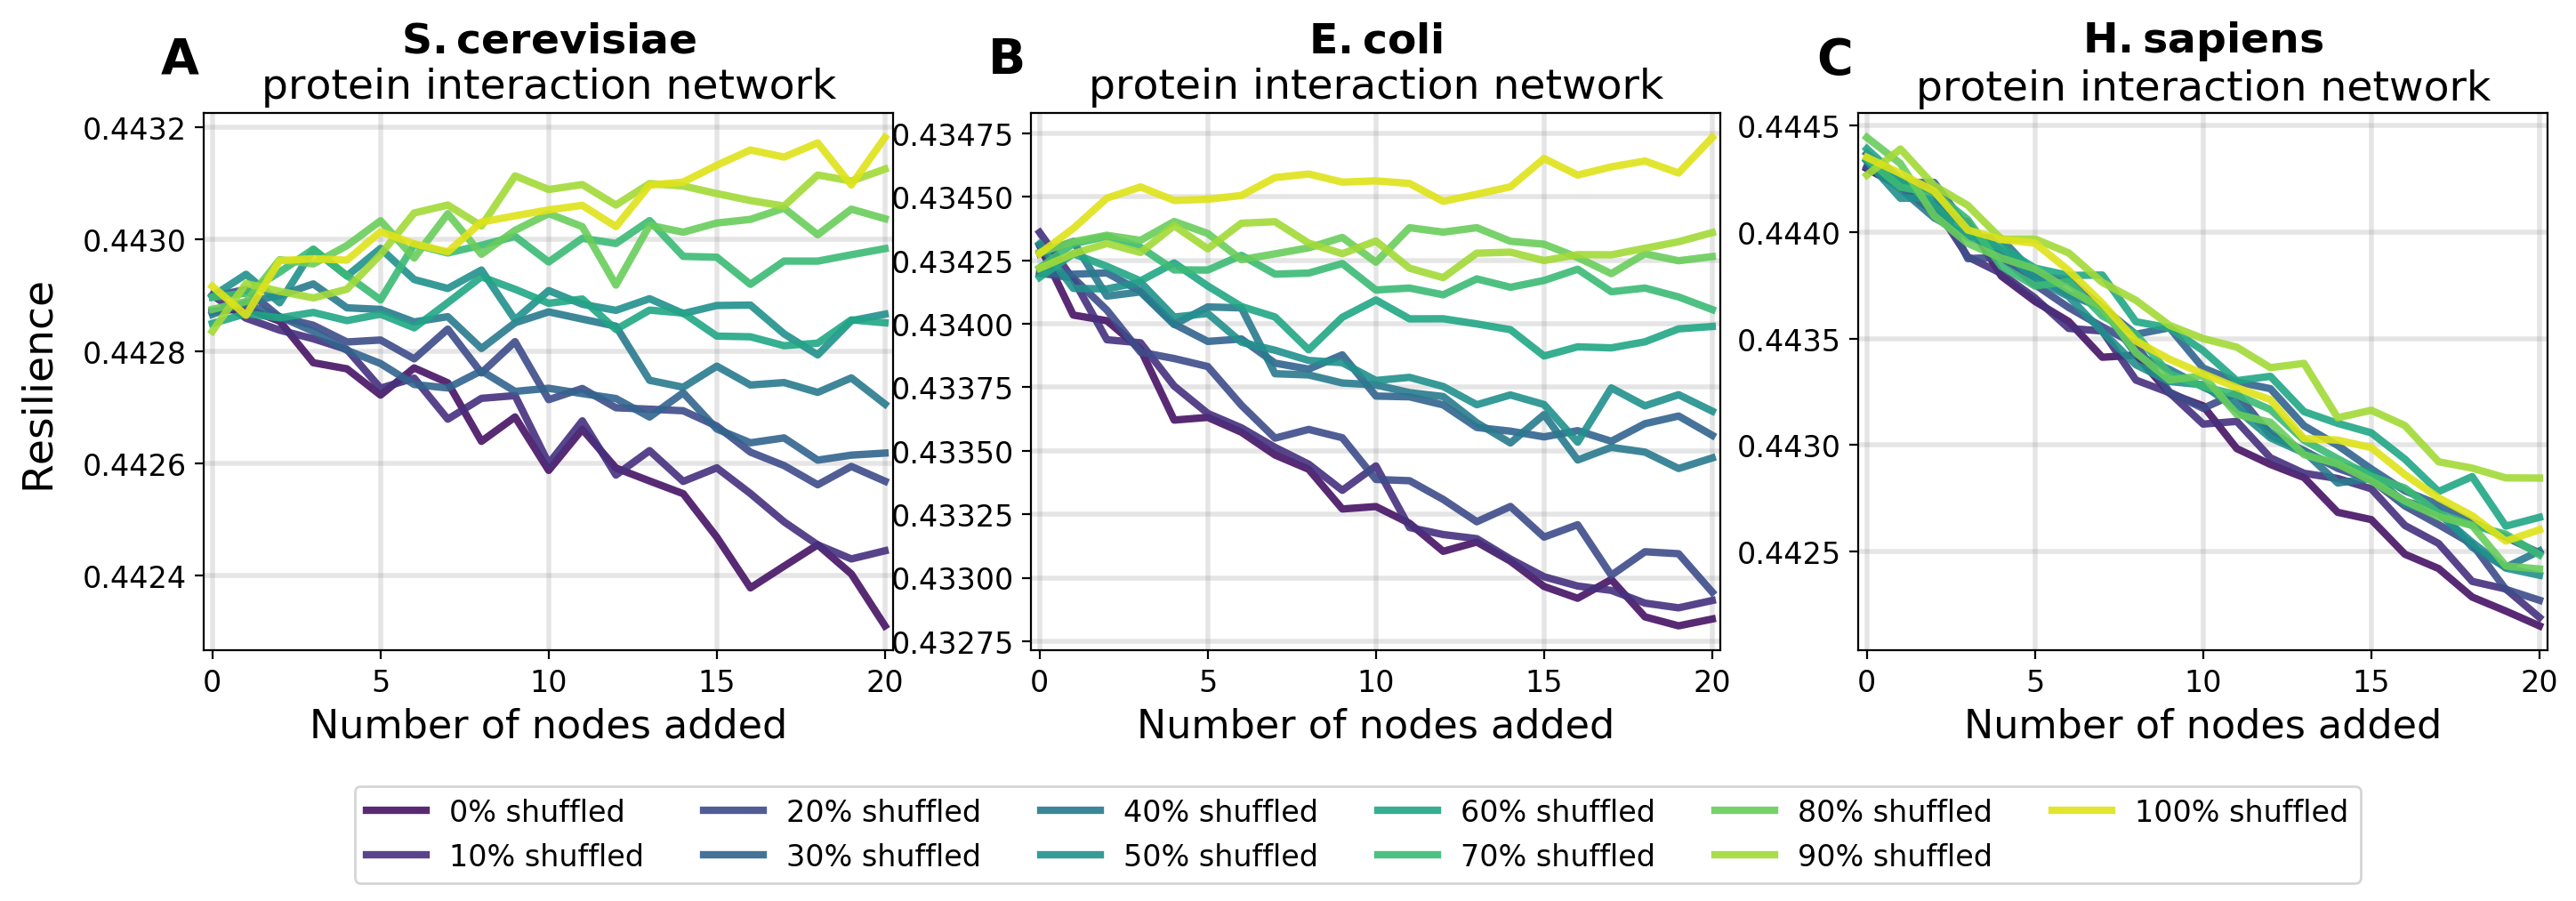

In [11]:
cols = plt.cm.viridis(np.linspace(0.05,0.95,len(noise_interval)))
cols = dict(zip(noise_interval, cols))

# fig, ax = plt.subplots(1, 3, figsize=(15,4), dpi=200, sharey=True)
# plt.subplots_adjust(hspace=0.015, wspace=0.1)
fig, ax = plt.subplots(1, 3, figsize=(17,4), dpi=200)
plt.subplots_adjust(hspace=0.015, wspace=0.2)
m = 4


for q, spec in enumerate(['sce','eco','hsa']):        
    for nois, nois_pres in out_dict[spec]['bio_smart'][m]['pres'].items():

        pres_i = np.array(nois_pres).mean(axis=0)
        xval_i = np.linspace(0,20,len(pres_i))
        
        xval_i_n, pres_i_n = average_every_n(xval_i, pres_i, 1)
        ax[q].plot(xval_i_n, pres_i_n, color=cols[nois], linewidth=3, alpha=0.9,
                   label='%i%% shuffled'%(int(nois*100)))
    
    ax[q].set_title(titles[spec],fontsize=17)
    ax[q].grid(linestyle='-', linewidth=2, alpha=0.25, color='#999999')
    ax[q].set_xlabel("Number of nodes added", fontsize=16)
    ax[q].set_xticks(np.linspace(0, t_out, 5))
    ax[q].set_xticklabels(np.linspace(0, t_out, 5, dtype=int))
    ax[q].set_xlim(-0.25, t_out+0.25)
    ax[q].tick_params(axis='both', which='major', labelsize=12)

alphabet = ['A', 'B', 'C']
for ai, a in enumerate(fig.axes):
    a.text(-0.035, 1.1, alphabet[ai], fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=a.transAxes, fontweight='bold')

ax[0].legend(fontsize=12, bbox_to_anchor=[3.15, -0.225], ncol=6)
ax[0].set_ylabel("Resilience", fontsize=17, labelpad=10)

# plt.savefig('../figs/pngs/gene_expression_noise.png', dpi=425, bbox_inches='tight')
# plt.savefig('../figs/pdfs/gene_expression_noise.pdf', bbox_inches='tight')

plt.show()

______________

# printout to paste into a batch.conf file for running this on the cluster

In [10]:
# # links_per_new = int(args[2])
# # method_used = str(args[3])
# # iterations = int(args[4])
# # seed_num = int(args[5])

# # python presilience_batch.py sce 4 random 4 5890
# import numpy as np
# nruns = 100
# for spec in ['hsa']:
#     for m in [4, 8, 16]:
#         for meth in ['bio_smart']:
#             for _ in range(nruns):
#                 print('python presilience_batch.py %s %s %s 4 %i'%(spec, m, meth, np.random.randint(100000)))